In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from math import floor

from matplotlib import pyplot as plt
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# Kiểm tra xem file 'tensor_y.npy' có tồn tại trong thư mục hiện tại không
if os.path.exists("./tensor_y.npy"):
    # Nếu file tồn tại, xoá file đó đi
    os.remove("./tensor_y.npy")

# Kiểm tra xem file 'tensor_x.npy' có tồn tại trong thư mục hiện tại không
if os.path.exists("./tensor_x.npy"):
    # Nếu file tồn tại, xoá file đó đi
    os.remove("./tensor_x.npy")

# Kiểm tra xem file 'val_tensor_x.npy' có tồn tại trong thư mục hiện tại không
if os.path.exists("./val_tensor_x.npy"):
    # Nếu file tồn tại, xoá file đó đi
    os.remove("./val_tensor_x.npy")

# Kiểm tra xem file 'val_tensor_y.npy' có tồn tại trong thư mục hiện tại không
if os.path.exists("./val_tensor_y.npy"):
    # Nếu file tồn tại, xoá file đó đi
    os.remove("./val_tensor_y.npy")


In [ ]:
epochs = 10
batch_size = 16
lr = 1e-3

alpha = 0.1

resize_height = 256
resize_width = 256

ratio = 4
train_val_split_perc = 0.9
val_test_split_perc = 0.5

In [ ]:
# Tạo một class Generator kế thừa từ keras.utils.Sequence để tạo ra một sequence (chuỗi) dữ liệu cho quá trình training hoặc evaluation
class Generator(keras.utils.Sequence):
    # Hàm khởi tạo của class, nhận vào hai danh sách: x và y
    def __init__(self, x: list, y: list):
        self.x = x  # Lưu trữ dữ liệu input
        self.y = y  # Lưu trữ nhãn (labels) tương ứng với dữ liệu input

    # Hàm trả về số lượng batches (mẻ) trong dữ liệu
    def __len__(self):
        return self.x.shape[0]  # Trả về số lượng phần tử trong dữ liệu x

    # Hàm này trả về một cặp (tuple) dữ liệu và nhãn tương ứng khi truyền vào index (chỉ số)
    def __getitem__(self, index):
        x = self.x[index]  # Lấy mẫu dữ liệu tại vị trí index
        y = self.y[index]  # Lấy nhãn tương ứng với mẫu dữ liệu tại vị trí index

        return x, y  # Trả về cặp dữ liệu và nhãn

    # Hàm này được gọi như một hàm thông thường và sẽ trả về một iterator
    # Iterator này sẽ duyệt qua tất cả các phần tử trong sequence
    def __call__(self):
        for i in range(self.__len__()):  # Duyệt qua từng phần tử trong sequence
            yield self.__getitem__(i)  # Trả về từng phần tử một theo format của generator

            # Kiểm tra nếu đây là phần tử cuối cùng trong sequence
            if i == self.__len__() - 1:
                self.on_epoch_end()  # Gọi hàm on_epoch_end khi kết thúc một epoch

In [ ]:
# Định nghĩa hàm preprocessing để tiền xử lý hình ảnh
def preprocessing(path, ratio, resize_height, resize_width):
    # Load hình ảnh từ đường dẫn
    y = tf.keras.utils.load_img(path)
    # Chuyển đổi hình ảnh sang mảng numpy
    y = tf.keras.utils.img_to_array(y)
    # Thay đổi kích thước của hình ảnh sang resize_height x resize_width sử dụng phương pháp bicubic
    y = tf.image.resize(y,
                        [resize_height, resize_width],
                        'bicubic',
                        antialias=True,  # Sử dụng antialias để làm mịn hình ảnh
                        )
    # Lấy kích thước của hình ảnh sau khi thay đổi kích thước
    height, width, _ = y.shape
    # Tạo hình ảnh x bằng cách giảm kích thước của hình ảnh y xuống theo tỉ lệ ratio
    x = tf.image.resize(y,
                        [height // ratio, width // ratio],  # Chia kích thước hiện tại cho tỉ lệ
                        'bicubic',
                        antialias=True,  # Sử dụng antialias để làm mịn hình ảnh khi giảm kích thước
                        )
    # Chuẩn hóa giá trị pixel của cả hai hình ảnh x và y để có giá trị từ 0 đến 1
    x = x / 255.0
    y = y / 255.0
    # Trả về cặp hình ảnh đã được tiền xử lý
    return x, y


In [ ]:
# Khởi tạo danh sách để lưu trữ đường dẫn của hình ảnh huấn luyện và kiểm thử
img_paths = []
val_img_paths = []

# Duyệt qua thư mục chứa hình ảnh huấn luyện
for dirname, _, filenames in os.walk('../input/div2k-dataset/DIV2K_train_HR'):
    for filename in filenames:
        # Thêm đường dẫn hình ảnh vào danh sách img_paths
        img_paths.append(os.path.join(dirname, filename))

# Duyệt qua thư mục chứa hình ảnh kiểm thử
for dirname, _, filenames in os.walk('../input/div2k-dataset/DIV2K_valid_HR'):
    for filename in filenames:
        # Thêm đường dẫn hình ảnh vào danh sách val_img_paths
        val_img_paths.append(os.path.join(dirname, filename))

# In ra số lượng hình ảnh trong tập dữ liệu
print('Dataset dimension: ', len(img_paths))

# Phân chia tập dữ liệu thành tập huấn luyện và tập kiểm thử dựa trên tỷ lệ train_val_split_perc
val_img_paths = img_paths[floor(len(img_paths) * train_val_split_perc):]
img_paths = img_paths[:floor(len(img_paths) * train_val_split_perc)]

# In ra số lượng hình ảnh trong tập huấn luyện và tập kiểm thử
print('Training: ', len(img_paths))


Dataset dimension:  900
Training:  810


In [ ]:
# Kiểm tra xem file 'tensor_x.npy' và 'tensor_y.npy' đã tồn tại hay chưa
if not (os.path.exists('./tensor_x.npy')) or not (os.path.exists('./tensor_y.npy')):
    # Nếu một trong hai file không tồn tại, thực hiện các bước sau:

    # Khởi tạo hai danh sách rỗng để lưu trữ hình ảnh ở độ phân giải thấp và cao
    img_lr = []
    img_hr = []

    # Duyệt qua tất cả các đường dẫn hình ảnh trong img_paths
    for i in tqdm(range(len(img_paths))):
        # Tiền xử lý mỗi hình ảnh và trả về hình ảnh ở độ phân giải thấp và cao
        x, y = preprocessing(img_paths[i], ratio, resize_height, resize_width)
        # Thêm hình ảnh độ phân giải thấp và cao vào danh sách tương ứng
        img_lr.append(x)
        img_hr.append(y)

    # Chuyển danh sách các hình ảnh độ phân giải thấp và cao thành tensors
    tensor_x = tf.convert_to_tensor(img_lr).numpy()
    tensor_y = tf.convert_to_tensor(img_hr).numpy()
    # Hiển thị kích thước của tensor_x để kiểm tra

    # Lưu các tensors vào file để sử dụng sau này
    np.save('./tensor_x.npy', tensor_x)
    np.save('./tensor_y.npy', tensor_y)
    # Cập nhật img_lr và img_hr bằng dữ liệu mới từ tensors
    img_lr = tensor_x
    img_hr = tensor_y
else:
    # Nếu cả hai file đều tồn tại, tải dữ liệu từ file
    img_lr = np.load('./tensor_x.npy')
    img_hr = np.load('./tensor_y.npy')



100%|██████████| 810/810 [03:12<00:00,  4.22it/s]


In [ ]:
# Kiểm tra xem file 'val_tensor_x.npy' và 'val_tensor_y.npy' đã tồn tại hay chưa
if not (os.path.exists('./val_tensor_x.npy')) or not (os.path.exists('./val_tensor_y.npy')):
    # Nếu một trong hai file không tồn tại, thực hiện các bước sau:

    # Khởi tạo hai danh sách rỗng để lưu trữ hình ảnh kiểm thử ở độ phân giải thấp và cao
    val_img_lr = []
    val_img_hr = []

    # Duyệt qua tất cả các đường dẫn hình ảnh kiểm thử trong val_img_paths
    for i in tqdm(range(len(val_img_paths))):
        # Tiền xử lý mỗi hình ảnh kiểm thử và trả về hình ảnh ở độ phân giải thấp và cao
        # Lưu ý: resize_height và resize_width được nhân đôi so với hình ảnh huấn luyện
        x, y = preprocessing(val_img_paths[i], ratio, resize_height * 2, resize_width * 2)
        # Thêm hình ảnh độ phân giải thấp và cao vào danh sách tương ứng
        val_img_lr.append(x)
        val_img_hr.append(y)

    # Chuyển danh sách các hình ảnh độ phân giải thấp và cao thành tensors
    val_tensor_x = tf.convert_to_tensor(val_img_lr).numpy()
    val_tensor_y = tf.convert_to_tensor(val_img_hr).numpy()

    # Lưu các tensors vào file để sử dụng sau này
    np.save('./val_tensor_x.npy', val_tensor_x)
    np.save('./val_tensor_y.npy', val_tensor_y)
    # Cập nhật val_img_lr và val_img_hr bằng dữ liệu mới từ tensors
    # Lưu ý: Có vẻ như có lỗi ở đây, nên là `val_img_lr = val_tensor_x` và `val_img_hr = val_tensor_y`
    val_img_lr = val_tensor_x
    val_img_hr = val_tensor_y
else:
    # Nếu cả hai file đều tồn tại, tải dữ liệu từ file
    val_img_lr = np.load('./val_tensor_x.npy')
    val_img_hr = np.load('./val_tensor_y.npy')


100%|██████████| 90/90 [00:23<00:00,  3.86it/s]


In [ ]:
# Khởi tạo một đối tượng Generator cho dữ liệu huấn luyện bằng cách truyền vào img_lr và img_hr
# Các đối tượng này chứa hình ảnh ở độ phân giải thấp và cao dành cho quá trình huấn luyện
train_generator = Generator(img_lr, img_hr)

# Khởi tạo một đối tượng Generator cho dữ liệu kiểm thử bằng cách sử dụng một phần của val_img_lr và val_img_hr
# Phần này tương ứng với tỷ lệ phần trăm val_test_split_perc của dữ liệu kiểm thử
# Điều này tạo ra một tập dữ liệu kiểm thử nhỏ để đánh giá hiệu suất trong quá trình huấn luyện
val_generator = Generator(val_img_lr[:floor(val_img_lr.shape[0] * val_test_split_perc)],
                          val_img_hr[:floor(val_img_lr.shape[0] * val_test_split_perc)])

# Khởi tạo một đối tượng Generator khác cho dữ liệu kiểm tra, sử dụng phần còn lại của dữ liệu sau khi đã tách phần dành cho kiểm thử
# Điều này đảm bảo rằng dữ liệu kiểm tra là độc lập với dữ liệu huấn luyện và dữ liệu kiểm thử
test_generator = Generator(val_img_lr[floor(val_img_lr.shape[0] * val_test_split_perc):],
                           val_img_hr[floor(val_img_lr.shape[0] * val_test_split_perc):])

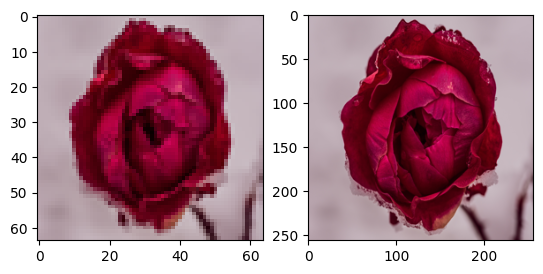

In [ ]:
# Lấy một cặp hình ảnh từ train_generator tại vị trí index 55.
# x là hình ảnh ở độ phân giải thấp (LR) và y là hình ảnh ở độ phân giải cao (HR) tương ứng
x, y = train_generator[55]

# Khởi tạo một biểu đồ mới để hiển thị hình ảnh
plt.figure()
# Thêm một subplot vào biểu đồ với cấu trúc 1 hàng 2 cột, đây là subplot thứ nhất
plt.subplot(1,2,1)
# Hiển thị hình ảnh ở độ phân giải thấp (x) trên subplot này
plt.imshow(x)
# Thêm subplot thứ hai vào biểu đồ với cùng cấu trúc (1 hàng 2 cột)
plt.subplot(1,2,2)
# Hiển thị hình ảnh ở độ phân giải cao (y) trên subplot này
plt.imshow(y)


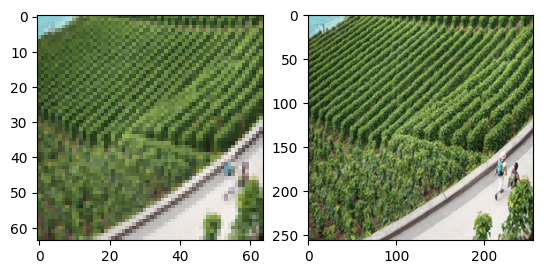

In [ ]:
x, y = train_generator[50]

plt.figure()
plt.subplot(1,2,1)
plt.imshow(x)
plt.subplot(1,2,2)
plt.imshow(y)

In [ ]:
# Tạo một tf.data.Dataset từ train_generator.
# Điều này cho phép tạo ra một luồng dữ liệu hiệu quả cho việc huấn luyện.
# output_shapes và output_types được đặt theo kích thước và kiểu dữ liệu của hình ảnh đầu vào và đầu ra.
train_dataset = tf.data.Dataset.from_generator(train_generator,
                                               output_shapes=([None, None, 3], [None, None, 3]),
                                               output_types=(x.dtype, y.dtype)).batch(batch_size)

# Sử dụng prefetch để tải trước dữ liệu trong khi dữ liệu khác đang được xử lý, cải thiện hiệu suất bằng cách giảm thời gian chờ.
train_dataset = train_dataset.prefetch(4)

# Cache dữ liệu để lưu trữ dữ liệu đã được xử lý, giúp giảm thời gian cần thiết để tải và xử lý dữ liệu trong các lần lặp tiếp theo.
train_dataset = train_dataset.cache()

# Sử dụng shuffle để xáo trộn dữ liệu. Điều này giúp mô hình không gặp phải tình trạng overfitting và học được các đặc điểm tổng quát hơn.
# len(train_generator) + 1 đảm bảo rằng toàn bộ bộ dữ liệu được xáo trộn đúng cách.
# reshuffle_each_iteration=True đảm bảo rằng dữ liệu được xáo trộn một cách khác nhau mỗi lần lặp qua bộ dữ liệu.
train_dataset = train_dataset.shuffle(len(train_generator) + 1, reshuffle_each_iteration=True)



In [ ]:
val_dataset = tf.data.Dataset.from_generator(val_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
val_dataset = val_dataset.prefetch(4)
val_dataset = val_dataset.cache()

In [ ]:
test_dataset = tf.data.Dataset.from_generator(test_generator,
                                                   output_shapes=([None, None, 3], [None, None, 3]),
                                                   output_types=(x.dtype, y.dtype)).batch(batch_size)
test_dataset = test_dataset.prefetch(4)
test_dataset = test_dataset.cache()

## Custom Loss Function Definiton

In [ ]:
# Định nghĩa một hàm tùy chỉnh MeanGradientError sử dụng trang trí @tf.function.
# Hàm này tính toán lỗi trung bình của gradient giữa hai tensor: targets và outputs.
@tf.function
def MeanGradientError(targets, outputs):
    # Tạo bộ lọc (kernel) Sobel để phát hiện cạnh theo hướng x và y.
    # Bộ lọc được mở rộng để phù hợp với số kênh của outputs và targets.
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype = outputs.dtype), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = outputs.dtype), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

    # Tính toán gradient theo cả hai hướng x và y cho outputs và targets bằng cách sử dụng phép tính convolution 2D.
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

    # Tính tổng bình phương của gradients theo cả hai hướng để nhận được độ lớn tổng thể của gradient.
    output_gradients = tf.math.add(output_gradient_x, output_gradient_y)
    target_gradients = tf.math.add(target_gradient_x, target_gradient_y)

    # Tính lỗi trung bình tuyệt đối giữa độ lớn gradient của outputs và targets.
    mge = tf.keras.metrics.mean_absolute_error(output_gradients, target_gradients)

    return mge

In [ ]:
# Sử dụng trang trí @tf.function để tạo một hàm TensorFlow, giúp tối ưu hóa việc tính toán.
# Hàm này định nghĩa hàm tổng thể để tính toán lỗ lực tổng cộng trong việc huấn luyện mô hình.
@tf.function
def overall_loss_func(y_true, y_pred):
    # Tính lỗi trung bình tuyệt đối (Mean Absolute Error - MAE) giữa giá trị thực tế và giá trị dự đoán.
    mae_loss = tf.keras.metrics.mean_absolute_error(y_true, y_pred)

    # Tính lỗi gradient trung bình (Mean Gradient Error - MGE) giữa giá trị thực tế và giá trị dự đoán.
    # Đây là hàm được định nghĩa ở trên.
    mge_loss = MeanGradientError(y_true, y_pred)

    # Kết hợp lỗi MAE và lỗi MGE để tạo ra lỗi tổng thể,
    # trong đó 'alpha' là một hệ số trọng số cho lỗi MGE.
    # 'alpha' cần được định nghĩa ở ngoài hàm này.
    return mae_loss + alpha * mge_loss


## Model implementation

In [ ]:
# Định nghĩa hàm SR_model để tạo ra mô hình super-resolution.
# upscale_factor: yếu tố nâng cấp độ phân giải, channels: số kênh màu của hình ảnh đầu vào.
def SR_model(upscale_factor=4, channels=3):
    # Định nghĩa các tham số chung cho lớp Conv2D, bao gồm hàm kích hoạt và kiểu padding.
    conv_args = {
        "activation": "relu",  # Sử dụng hàm kích hoạt ReLU.
        "padding": "same",  # Sử dụng padding "same" để kích thước hình ảnh đầu ra bằng hình ảnh đầu vào.
    }
    # Tạo lớp đầu vào với kích thước không xác định (None) và số kênh cố định.
    inputs = layers.Input(shape=(None, None, channels))
    # Tạo các lớp Conv2D với số lượng bộ lọc khác nhau và kích thước kernel.
    x = layers.Conv2D(64, 5, **conv_args)(inputs)  # 64 bộ lọc, kernel size 5x5.
    x = layers.Conv2D(64, 3, **conv_args)(x)      # 64 bộ lọc, kernel size 3x3.
    x = layers.Conv2D(32, 3, **conv_args)(x)      # 32 bộ lọc, kernel size 3x3.
    # Cuối cùng, một lớp Conv2D với số bộ lọc bằng số kênh nhân với bình phương của yếu tố nâng cấp.
    x = layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    # Sử dụng tf.nn.depth_to_space để tái cấu trúc đầu ra cho việc nâng cấp độ phân giải.
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    # Trả về một đối tượng Model với đầu vào và đầu ra đã được xác định.
    return keras.Model(inputs, outputs)


In [ ]:
net = SR_model()
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    4864      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 48)    13872     
                                                                 
 tf.nn.depth_to_space (TFOp  (None, None, None, 3)     0         
 Lambda)                                                         
                                                             

In [ ]:
net.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=overall_loss_func, metrics=['mae', MeanGradientError])

## Training

In [ ]:
history = net.fit(
        x = train_dataset,
        epochs = epochs,
        verbose = 1,
        validation_data = val_dataset
)

Epoch 1/10
51/51 [==============================] - 8s 55ms/step - loss: 0.7402 - mae: 0.2683 - MeanGradientError: 4.7192 - val_loss: 0.6166 - val_mae: 0.1854 - val_MeanGradientError: 4.3126
Epoch 2/10
51/51 [==============================] - 1s 25ms/step - loss: 0.5844 - mae: 0.1745 - MeanGradientError: 4.0985 - val_loss: 0.5546 - val_mae: 0.1492 - val_MeanGradientError: 4.0542
Epoch 3/10
51/51 [==============================] - 1s 26ms/step - loss: 0.5035 - mae: 0.1186 - MeanGradientError: 3.8493 - val_loss: 0.4838 - val_mae: 0.0962 - val_MeanGradientError: 3.8758
Epoch 4/10
51/51 [==============================] - 1s 25ms/step - loss: 0.4678 - mae: 0.0934 - MeanGradientError: 3.7443 - val_loss: 0.4514 - val_mae: 0.0864 - val_MeanGradientError: 3.6504
Epoch 5/10
51/51 [==============================] - 1s 25ms/step - loss: 0.4419 - mae: 0.0846 - MeanGradientError: 3.5730 - val_loss: 0.4357 - val_mae: 0.0823 - val_MeanGradientError: 3.5340
Epoch 6/10
51/51 [===========================

## Visualization of training curves

dict_keys(['loss', 'mae', 'MeanGradientError', 'val_loss', 'val_mae', 'val_MeanGradientError'])


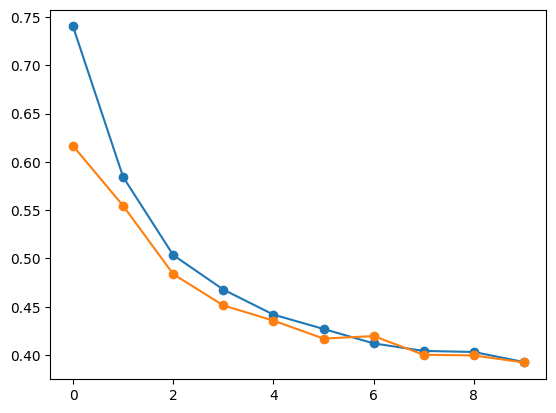

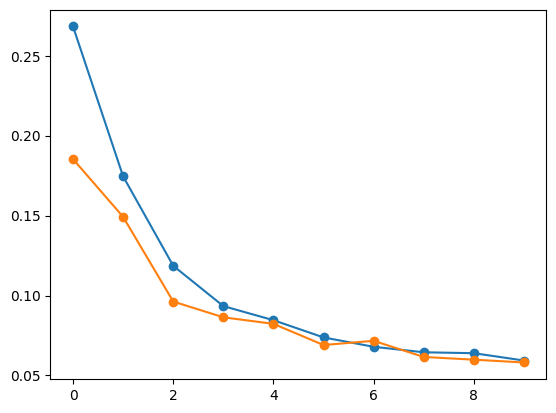

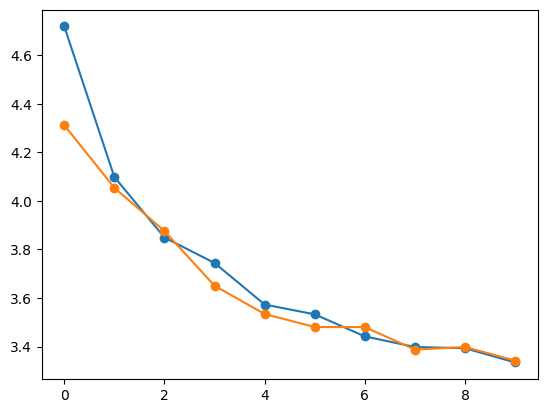

In [ ]:
print(history.history.keys())
plt.figure()
plt.plot(history.history['loss'], label='train', marker='o')
plt.plot(history.history['val_loss'], label='val', marker='o')

plt.figure()
plt.plot(history.history['mae'], label='train', marker='o')
plt.plot(history.history['val_mae'], label='val', marker='o')

plt.figure()
plt.plot(history.history['MeanGradientError'], label='train', marker='o')
plt.plot(history.history['val_MeanGradientError'], label='val', marker='o')

## Testing

In [ ]:
outputs = net.predict(test_dataset)

26/26 [==============================] - 0s 14ms/step


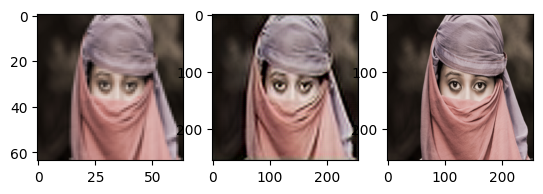

In [ ]:
x, y = test_generator[9]
plt.figure()
plt.subplot(1,3,1)
plt.imshow(x)
plt.subplot(1,3,2)
plt.imshow(outputs[9])
plt.subplot(1,3,3)
plt.imshow(y)

In [ ]:
pip install numpy==1.23.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.3 which is incompatible.
cudf 23.